# H12 genome-wide selection scans

This notebook runs genome-wide selection scans.

In [1]:
import zarr
from pyprojroot import here
import pandas as pd
import numpy as np
import allel
import yaml
import matplotlib.pyplot as plt
import functools
import seaborn as sns
import dask.array as da
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
callset_haps_path = here() / 'data/external/ag1000g/phase2/AR1/haplotypes/main/zarr/ag1000g.phase2.ar1.haplotypes'
callset_haps = zarr.open_consolidated(str(callset_haps_path))
callset_haps

<zarr.hierarchy.Group '/'>

In [3]:
df_haps_a = pd.read_csv(here() / 'data/external/ag1000g/phase2/AR1/haplotypes/main/haplotypes.autosomes.meta.txt',
                        sep='\t', index_col=0)
df_haps_a.head()

,label,ox_code,population,label_aug,country,region,sex,m_s
0,AA0040-Ca,AA0040-C,GHcol,"AA0040-Ca [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
1,AA0040-Cb,AA0040-C,GHcol,"AA0040-Cb [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
2,AA0041-Ca,AA0041-C,GHcol,"AA0041-Ca [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
3,AA0041-Cb,AA0041-C,GHcol,"AA0041-Cb [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
4,AA0042-Ca,AA0042-C,GHcol,"AA0042-Ca [Ghana, Takoradi, M F]",Ghana,Takoradi,F,M


In [4]:
df_haps_x = pd.read_csv(here() / 'data/external/ag1000g/phase2/AR1/haplotypes/main/haplotypes.X.meta.txt',
                        sep='\t', index_col=0)
df_haps_x.head()

,label,ox_code,population,label_aug,country,region,sex,m_s
0,AA0040-Ca,AA0040-C,GHcol,"AA0040-Ca [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
1,AA0040-Cb,AA0040-C,GHcol,"AA0040-Cb [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
2,AA0041-Ca,AA0041-C,GHcol,"AA0041-Ca [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
3,AA0041-Cb,AA0041-C,GHcol,"AA0041-Cb [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
4,AA0042-Ca,AA0042-C,GHcol,"AA0042-Ca [Ghana, Takoradi, M F]",Ghana,Takoradi,F,M


In [5]:
with open('pop_defs.yml', mode='r') as f:
    pop_defs = yaml.safe_load(f)
list(pop_defs)

['ao_col',
 'bf_col',
 'bf_gam',
 'ci_col',
 'cm_sav_gam',
 'fr_gam',
 'ga_gam',
 'gh_col',
 'gh_gam',
 'gm',
 'gn_gam',
 'gq_gam',
 'gw',
 'ke',
 'ug_gam']

In [6]:
for pop, config in pop_defs.items():
    print(pop, 
          config['label'],
          config['h12_window_size'],
          len(df_haps_a.query(config['query'])))

ao_col Angola An. coluzzii 6000 156
bf_col Burkina Faso An. coluzzii 1000 150
bf_gam Burkina Faso An. gambiae 1000 184
ci_col Cote d'Ivoire An. coluzzii 2000 142
cm_sav_gam Cameroon (savanna) An. gambiae 1000 192
fr_gam Mayotte An. gambiae 16000 48
ga_gam Gabon An. gambiae 10000 138
gh_col Ghana An. coluzzii 1400 110
gh_gam Ghana An. gambiae 1600 24
gm The Gambia 2600 130
gn_gam Guinea An. gambiae 1000 80
gq_gam Bioko An. gambiae 7000 18
gw Guinea-Bissau 1000 182
ke Kenya 60000 96
ug_gam Uganda An. gambiae 1000 224


In [7]:
import pyfasta
genome_path = here() / 'data/external/vectorbase/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.fa'
genome = pyfasta.Fasta(str(genome_path), key_fn=lambda x: x.split()[0])
for seq_id in genome:
    print(seq_id, len(genome[seq_id]))

2R 61545105
3R 53200684
2L 49364325
UNKN 42389979
3L 41963435
X 24393108
Y_unplaced 237045
Mt 15363


In [8]:
def compute_h12(pop, chromosome, window_size, window_step, centromere_pad=10_000):
    
    # setup data
    if chromosome == 'X':
        loc_haps = df_haps_x.query(pop_defs[pop]['query']).index.values
        pos = callset_haps[chromosome]['variants/POS'][:]
        ht = allel.GenotypeDaskArray(callset_haps[chromosome]['calldata/GT']).to_haplotypes()
        ht_pop = da.take(ht, loc_haps, axis=1).compute()
        
    else:
        # concatenate data from both arms
        # remember, right arm goes on the left
        loc_haps = df_haps_a.query(pop_defs[pop]['query']).index.values
        arm_r = f'{chromosome}R'
        arm_l = f'{chromosome}L'
        pos_r = callset_haps[arm_r]['variants/POS'][:]
        pos_l = callset_haps[arm_l]['variants/POS'][:]
        pos = np.concatenate([pos_r, pos_l + len(genome[arm_r]) + centromere_pad])
        ht_r = allel.GenotypeDaskArray(callset_haps[arm_r]['calldata/GT']).to_haplotypes()
        ht_l = allel.GenotypeDaskArray(callset_haps[arm_l]['calldata/GT']).to_haplotypes()
        ht = da.concatenate([ht_r, ht_l], axis=0)
        ht_pop = da.take(ht, loc_haps, axis=1).compute()
        
    # perform the scan
    windows = allel.moving_statistic(pos, statistic=lambda v: [v[0], v[-1]], size=window_size, step=window_step)
    h1, h12, h123, h2_h1 = allel.moving_garud_h(ht_pop, size=window_size, step=window_step)
    
    return windows, h1, h12, h123, h2_h1


In [9]:
h12_root = zarr.open(str(here() / 'data/gwss/h12/h12.zarr'))

In [10]:
def run_h12(pop, chromosome, window_size=None, window_step=200):
    if not window_size:
        window_size = pop_defs[pop]['h12_window_size']
    if not window_step:
        window_step = window_size // 2
    
    # setup zarr group to store data
    grp_path = f'/{pop}/{window_size}/{window_step}/{chromosome}'
    grp = h12_root.require_group(grp_path)
    complete = grp.attrs.get('complete', False)
    
    if complete:
        # previously run, load from zarr
        windows = grp['windows'][:]
        h1 = grp['h1'][:]
        h12 = grp['h12'][:]
        h123 = grp['h123'][:]
        h2_h1 = grp['h2_h1'][:]
        
    else:
        # run scan and save to zarr
        windows, h1, h12, h123, h2_h1 = compute_h12(pop, 
                                                    chromosome=chromosome,
                                                    window_size=window_size,
                                                    window_step=window_step)
        grp.create_dataset('windows', data=windows, overwrite=True)
        grp.create_dataset('h1', data=h1, overwrite=True)
        grp.create_dataset('h12', data=h12, overwrite=True)
        grp.create_dataset('h123', data=h123, overwrite=True)
        grp.create_dataset('h2_h1', data=h2_h1, overwrite=True)
        grp.attrs['complete'] = True

    # plot results for inspection
    x = windows.mean(axis=1)
    y = h12
    fig, ax = plt.subplots(facecolor='w', figsize=(x.max()/1e7, 3))
    ax.plot(x, y, linestyle=' ', marker='o', mec='k', mfc='none', markersize=1)
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks/1e6)
    ax.set_xlabel(f'Chromosome {chromosome} position (Mbp)')
    ax.set_ylabel('H12')
    ax.set_xlim(0, windows[-1, 1])
    ax.set_ylim(0, 1)
    ax.set_title(f"{pop_defs[pop]['label']}")
    plt.show()


In [11]:
pops = list(pop_defs)
pops

['ao_col',
 'bf_col',
 'bf_gam',
 'ci_col',
 'cm_sav_gam',
 'fr_gam',
 'ga_gam',
 'gh_col',
 'gh_gam',
 'gm',
 'gn_gam',
 'gq_gam',
 'gw',
 'ke',
 'ug_gam']

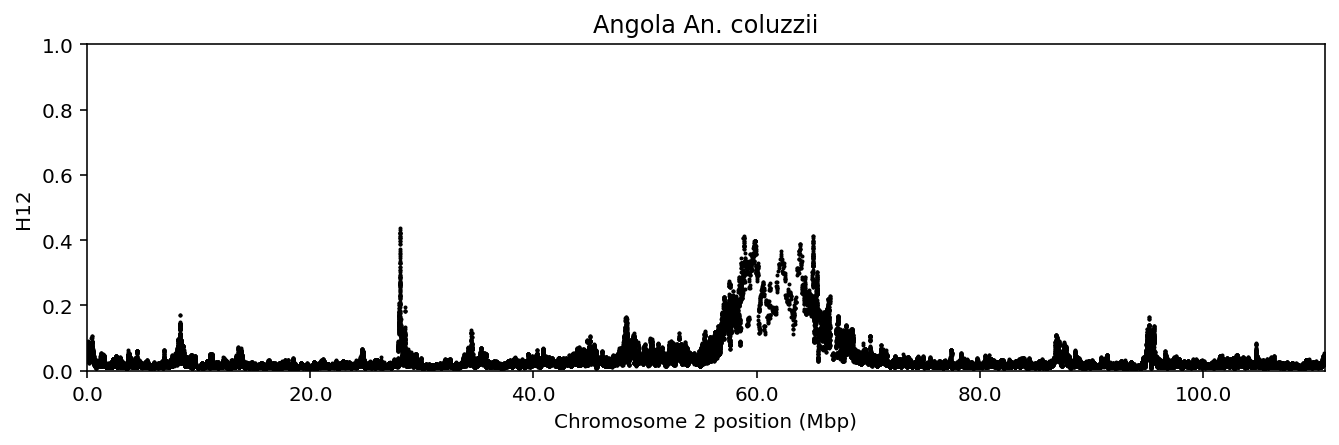

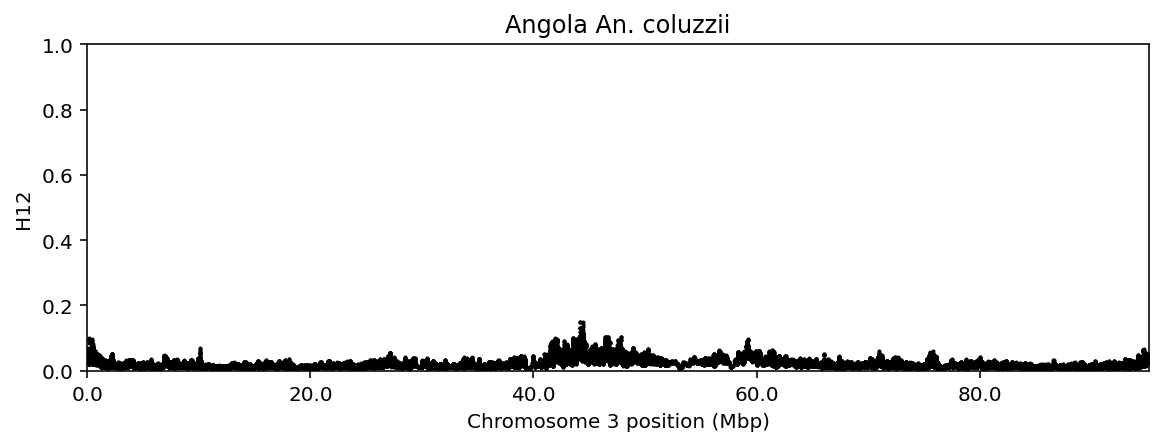

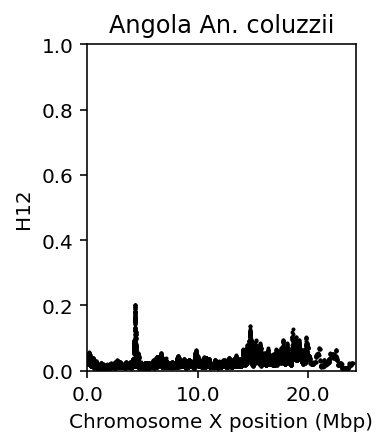

In [12]:
for chromosome in '2', '3', 'X':
    run_h12(pops[0], chromosome)


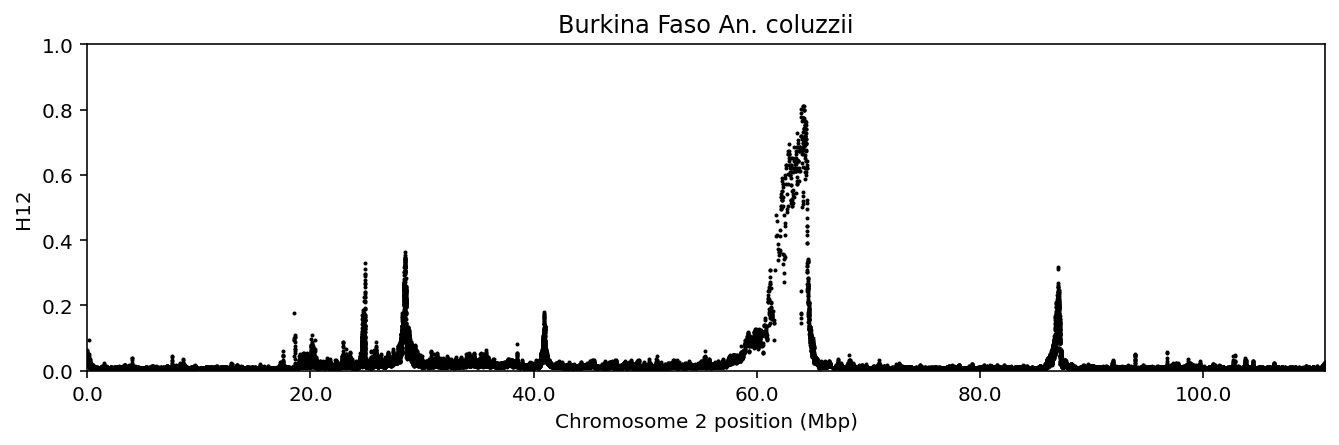

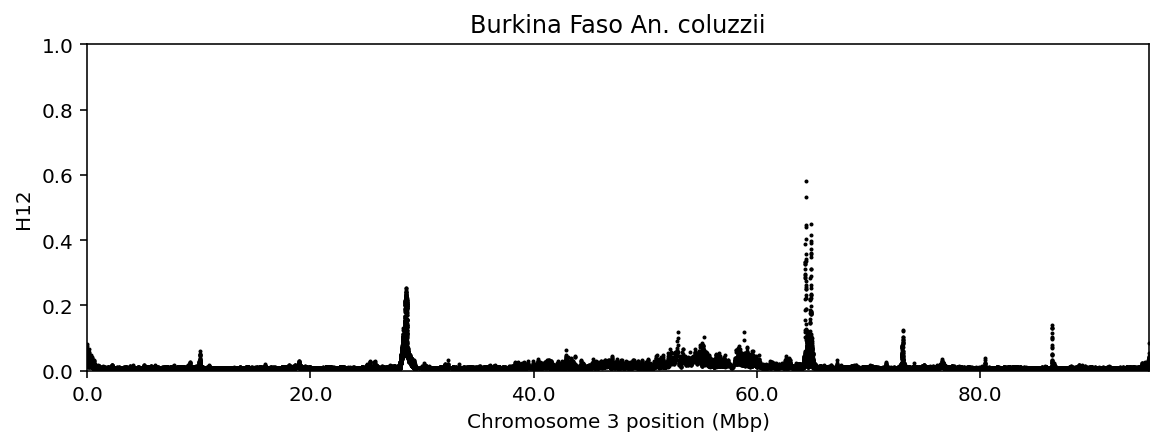

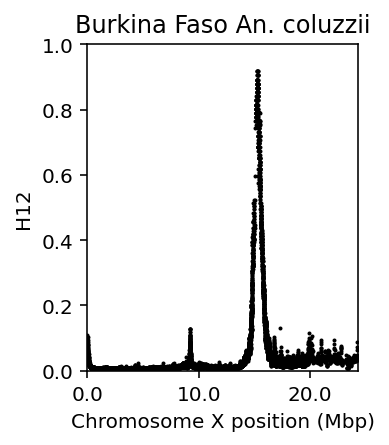

In [13]:
for chromosome in '2', '3', 'X':
    run_h12(pops[1], chromosome)


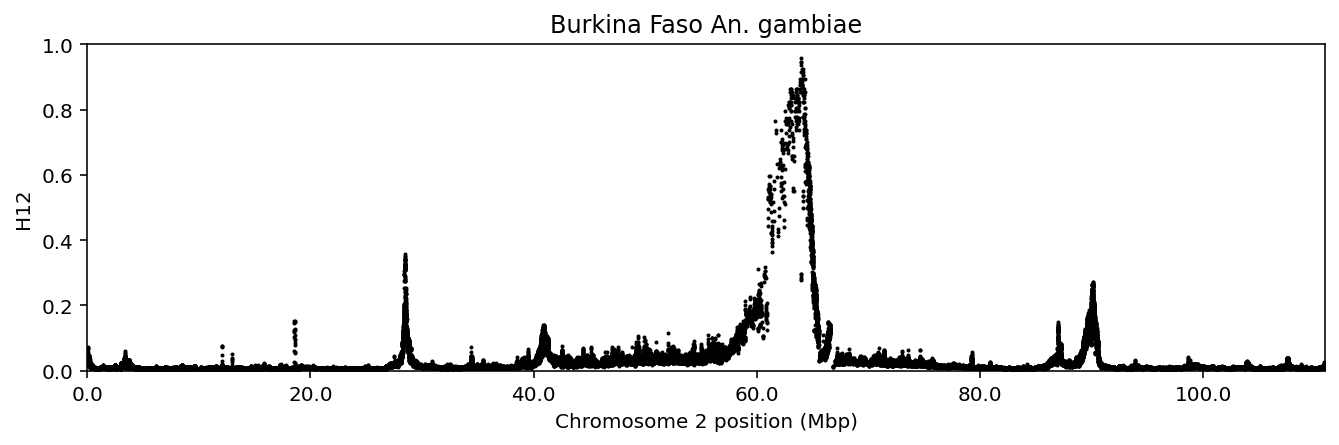

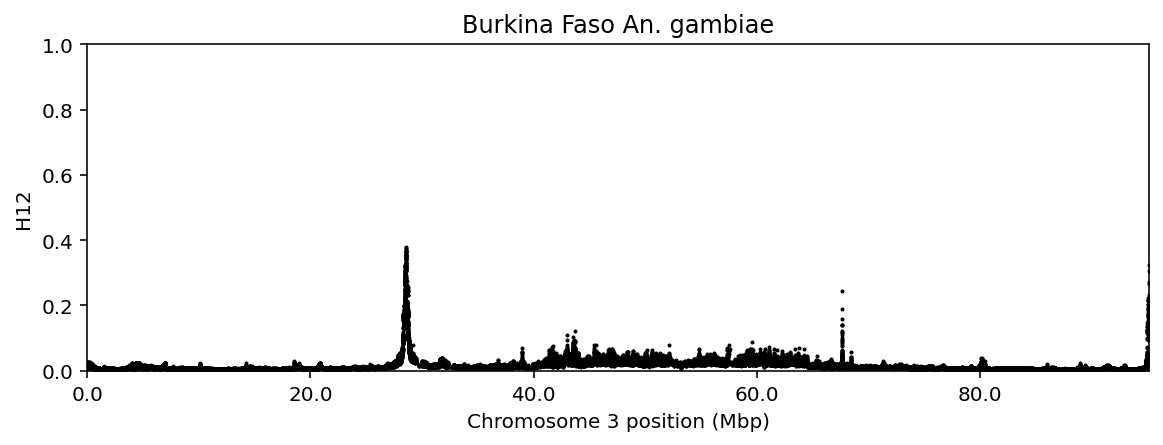

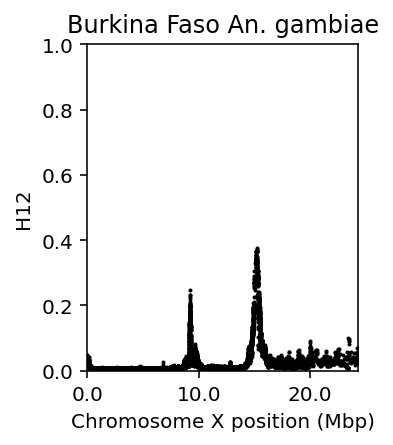

In [14]:
for chromosome in '2', '3', 'X':
    run_h12(pops[2], chromosome)


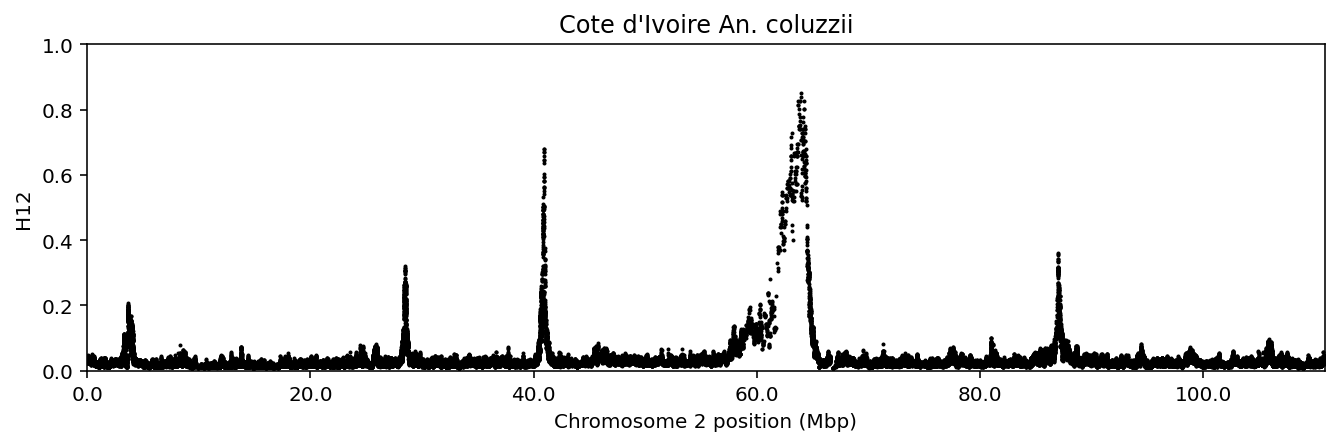

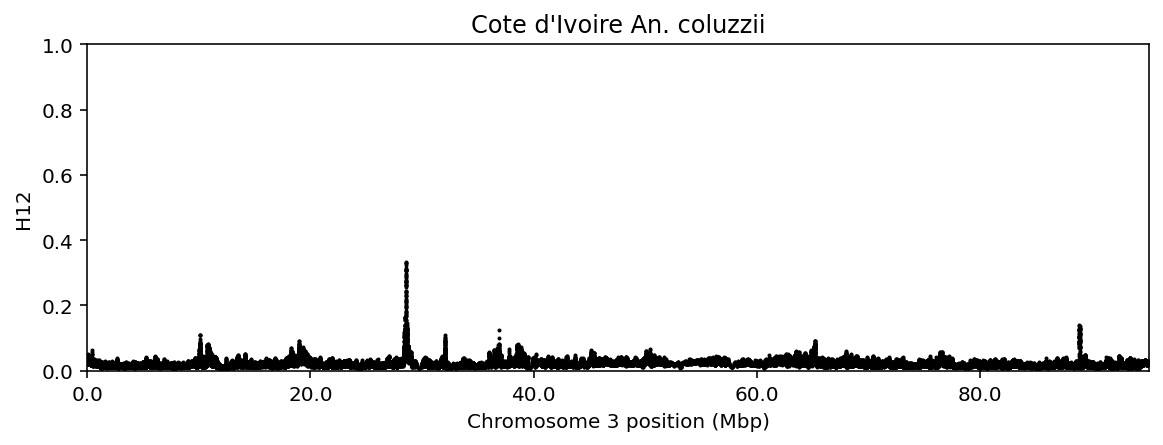

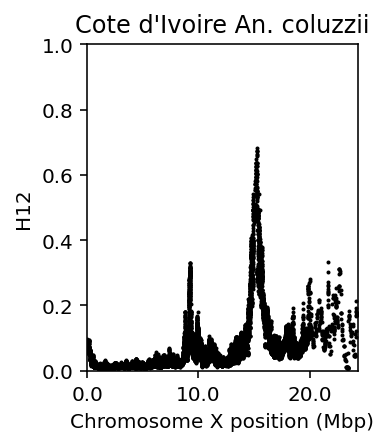

In [15]:
for chromosome in '2', '3', 'X':
    run_h12(pops[3], chromosome)


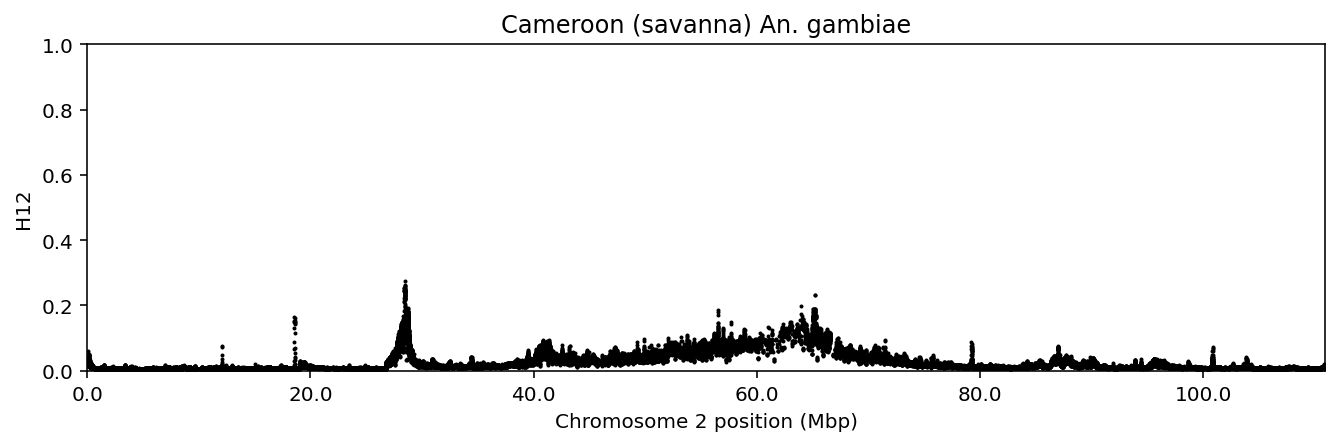

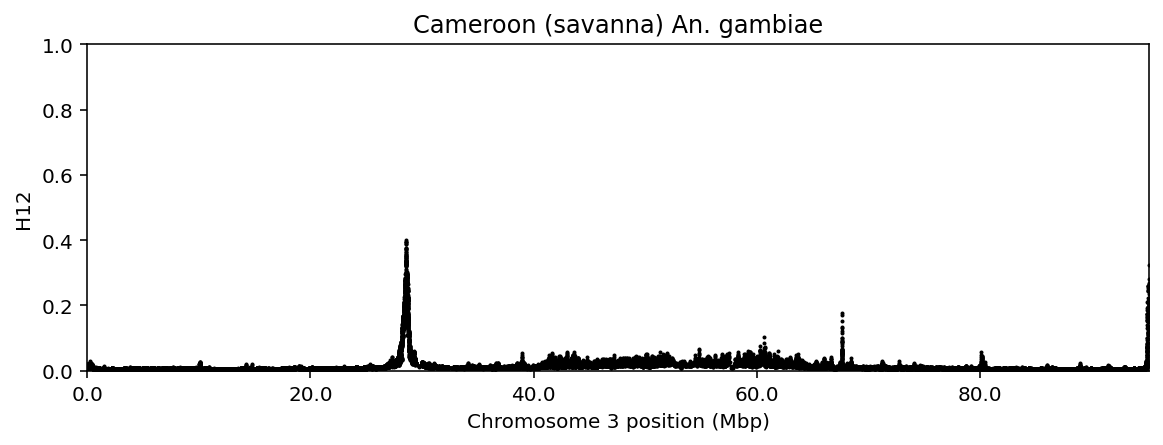

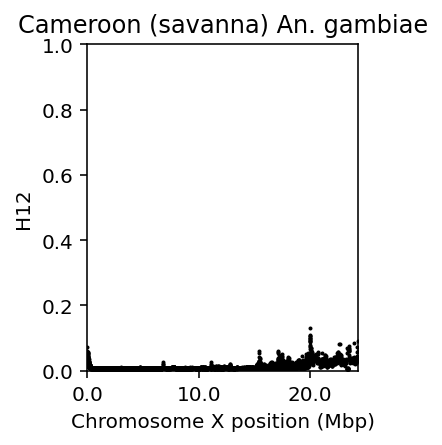

In [16]:
for chromosome in '2', '3', 'X':
    run_h12(pops[4], chromosome)


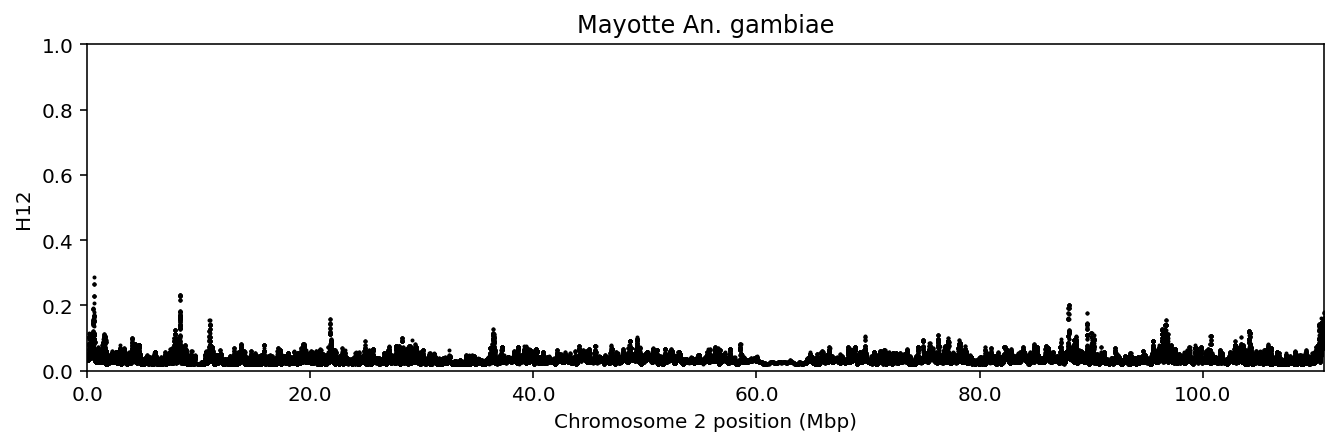

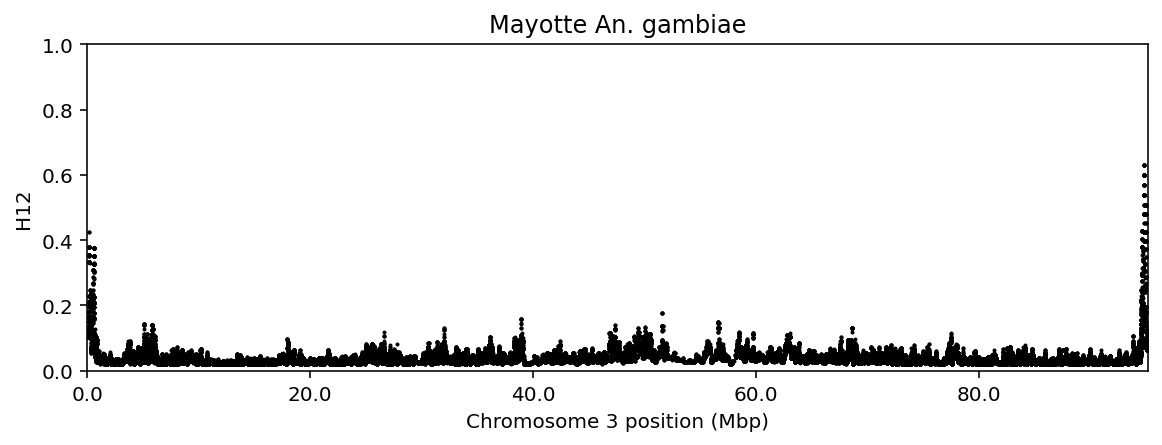

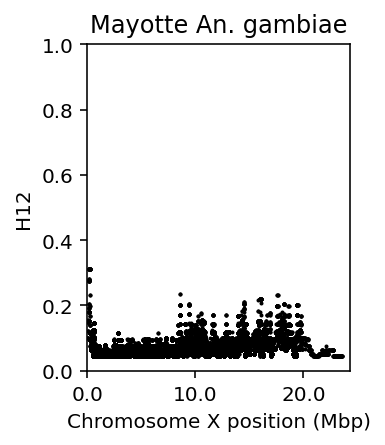

In [17]:
for chromosome in '2', '3', 'X':
    run_h12(pops[5], chromosome)


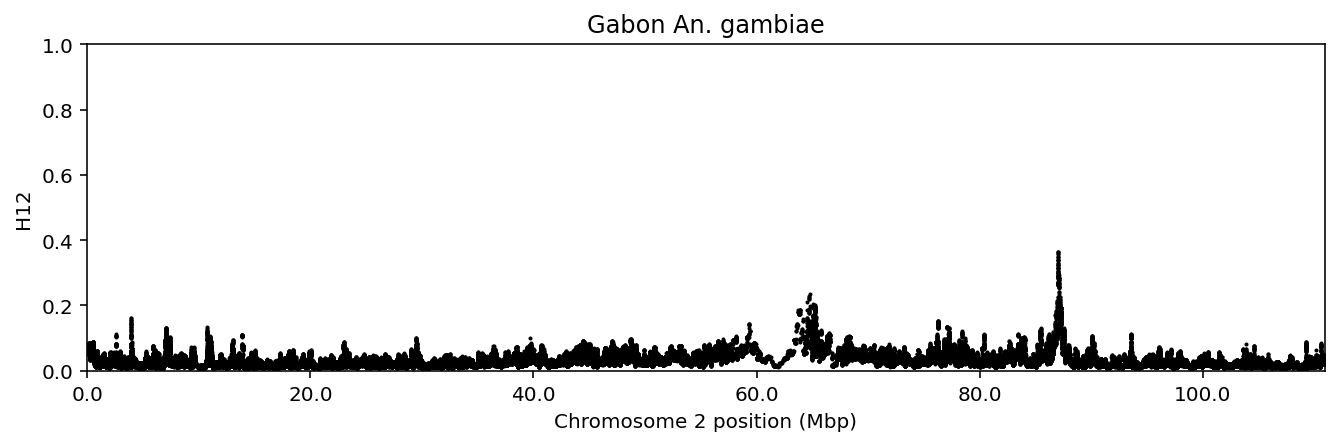

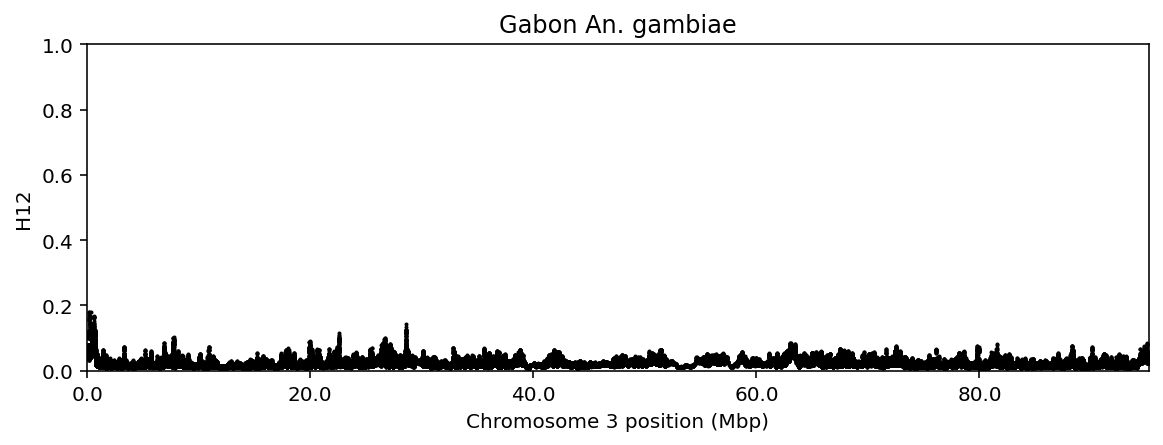

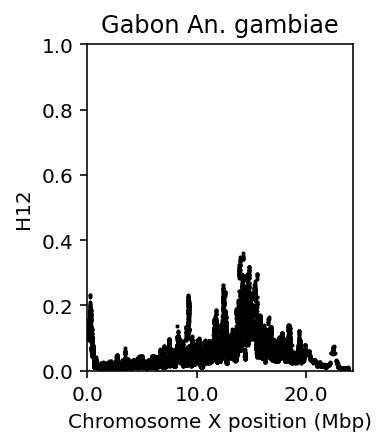

In [18]:
for chromosome in '2', '3', 'X':
    run_h12(pops[6], chromosome)


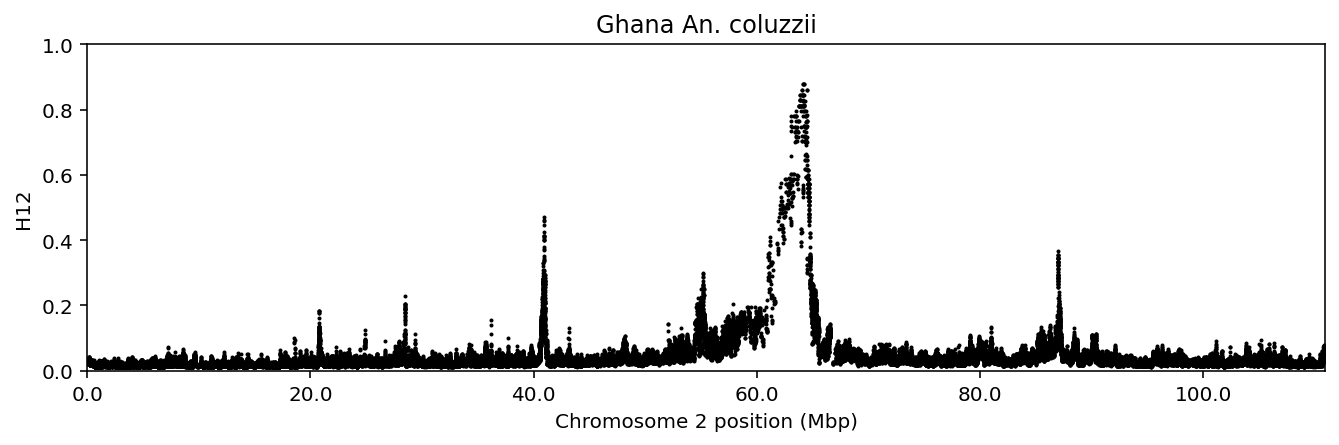

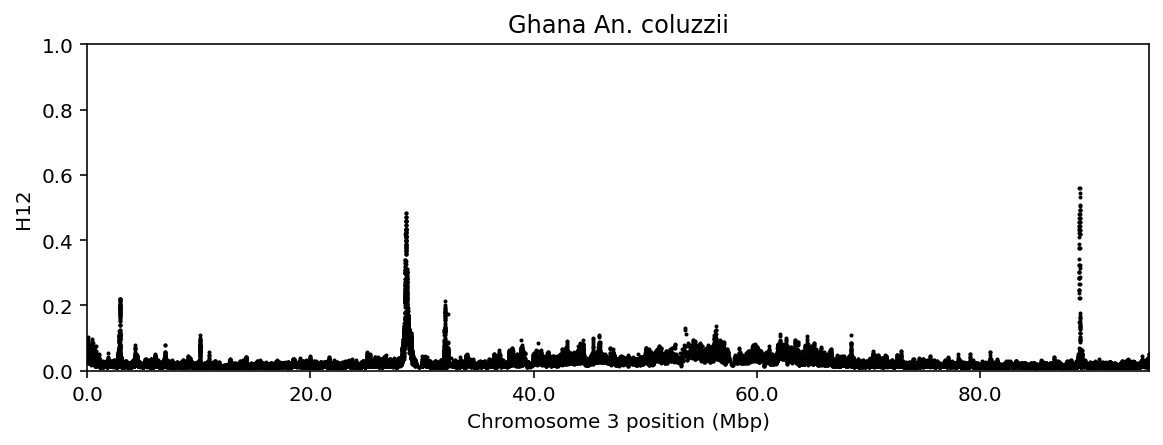

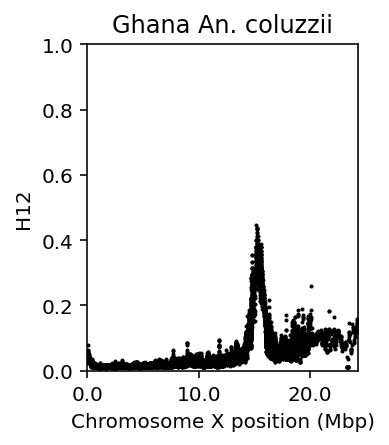

In [19]:
for chromosome in '2', '3', 'X':
    run_h12(pops[7], chromosome)


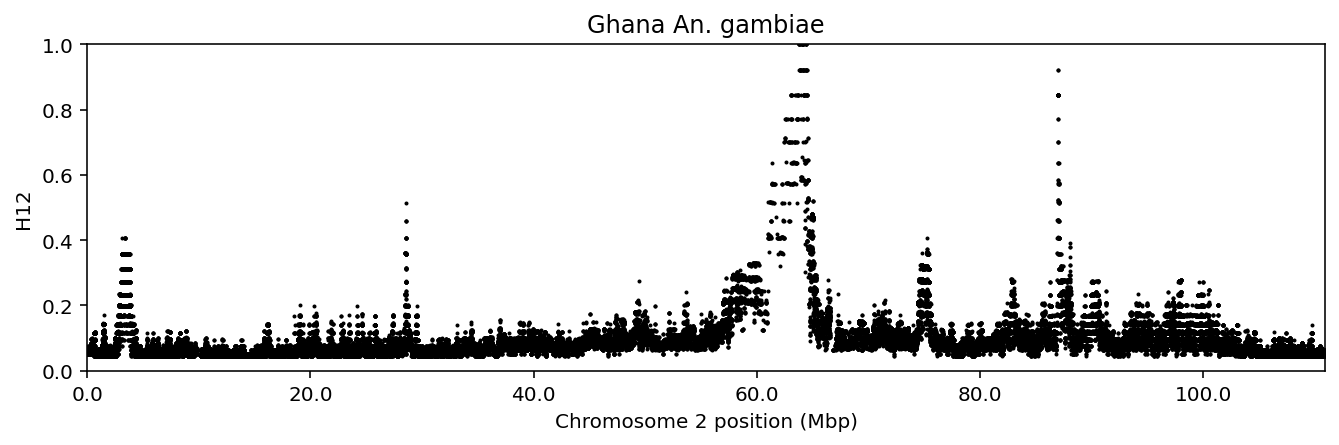

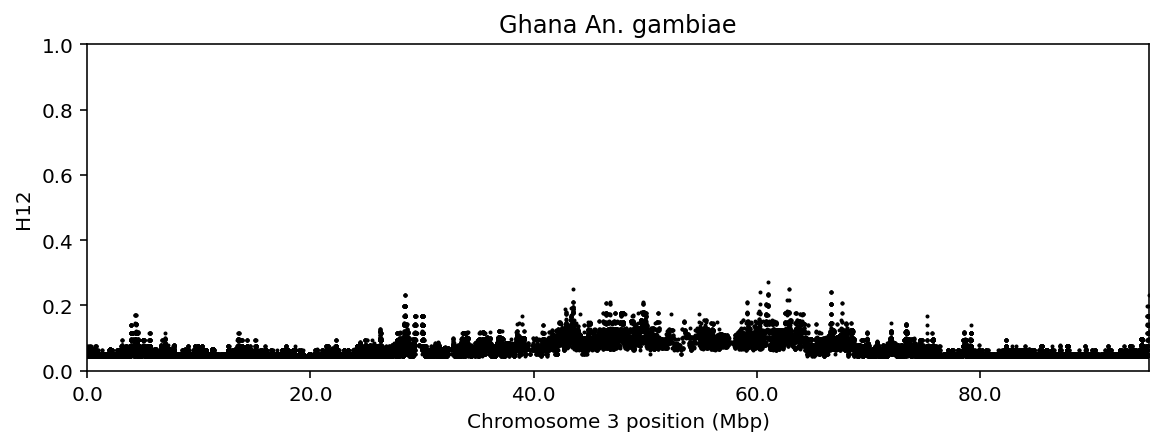

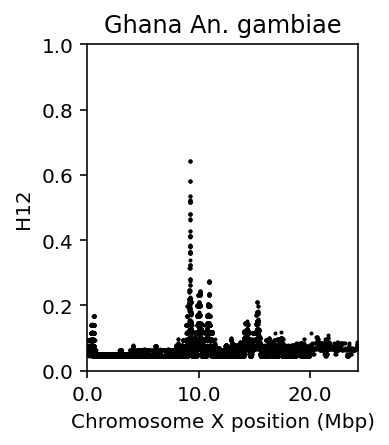

In [20]:
for chromosome in '2', '3', 'X':
    run_h12(pops[8], chromosome)


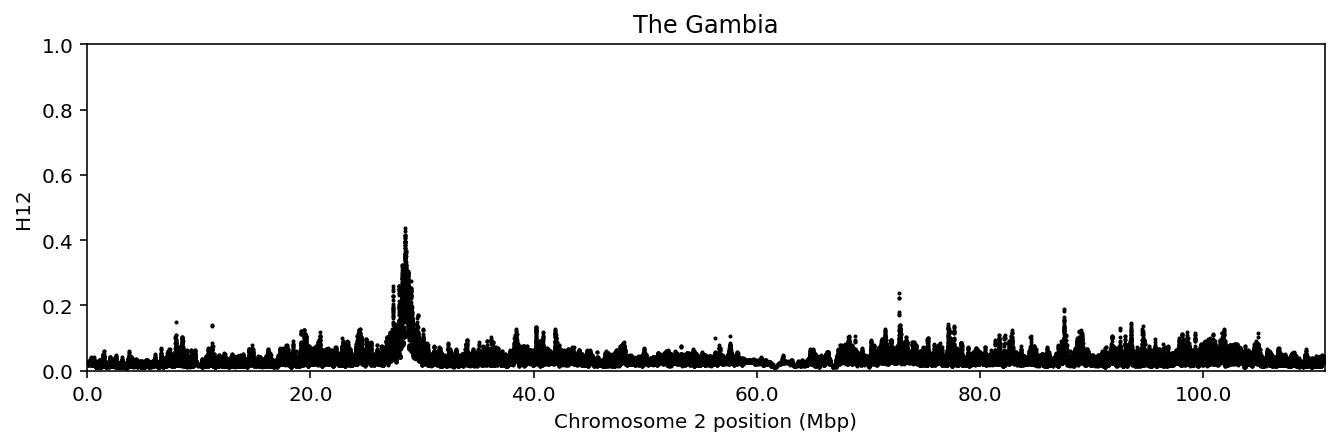

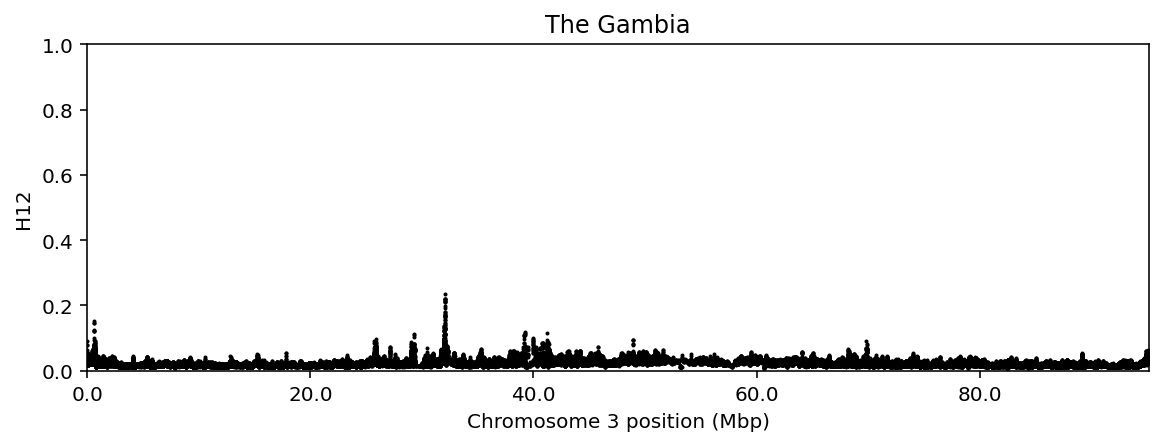

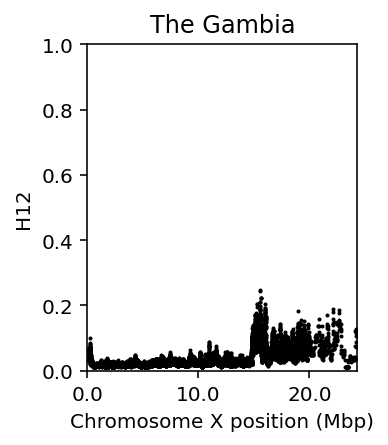

In [21]:
for chromosome in '2', '3', 'X':
    run_h12(pops[9], chromosome)


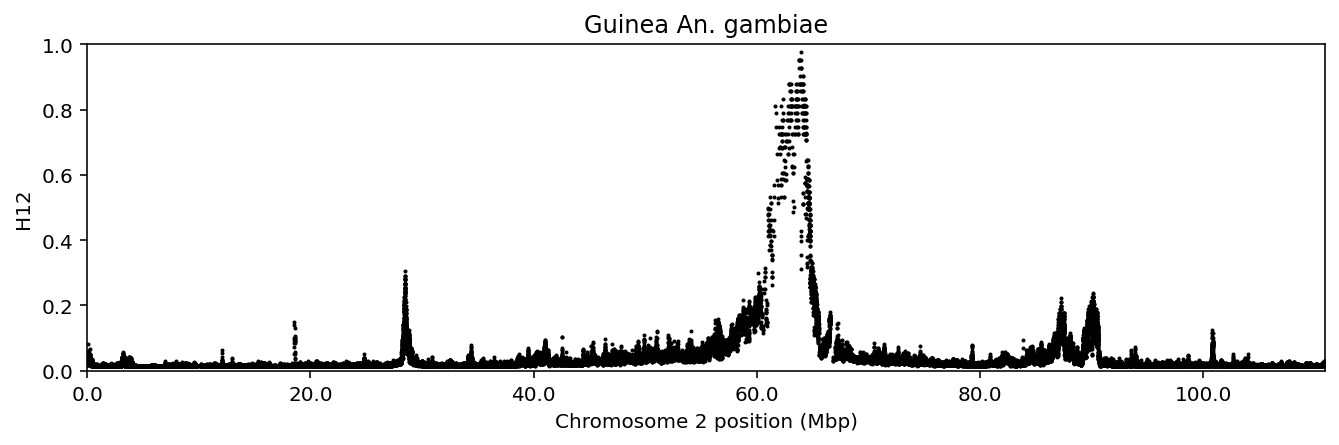

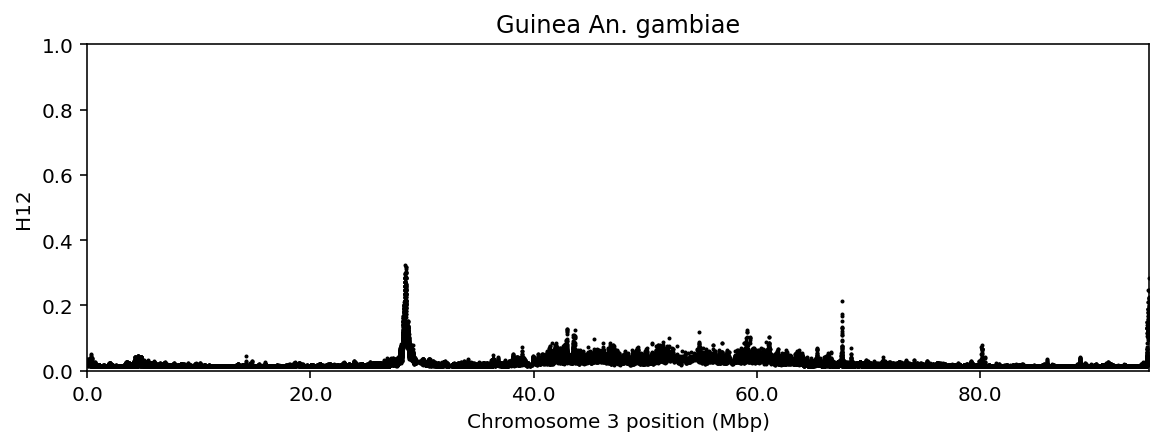

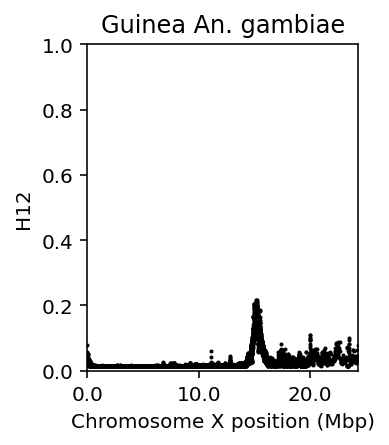

In [22]:
for chromosome in '2', '3', 'X':
    run_h12(pops[10], chromosome)


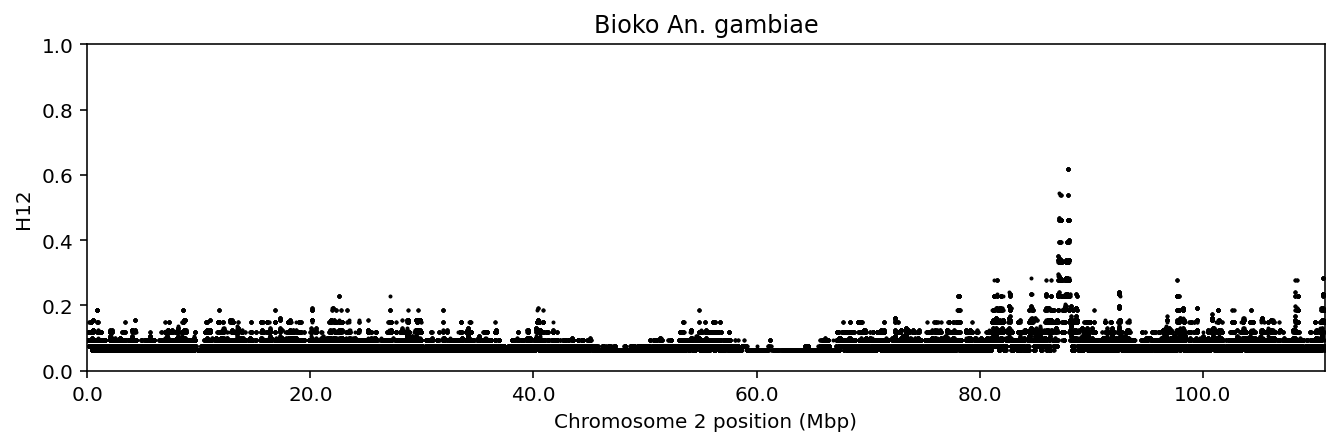

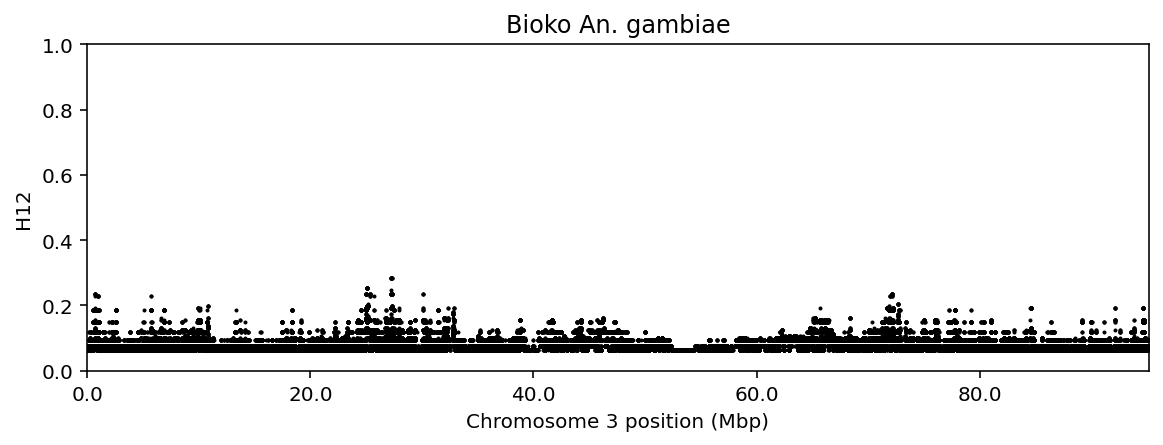

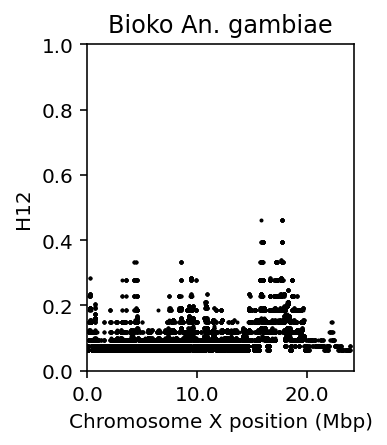

In [23]:
for chromosome in '2', '3', 'X':
    run_h12(pops[11], chromosome)


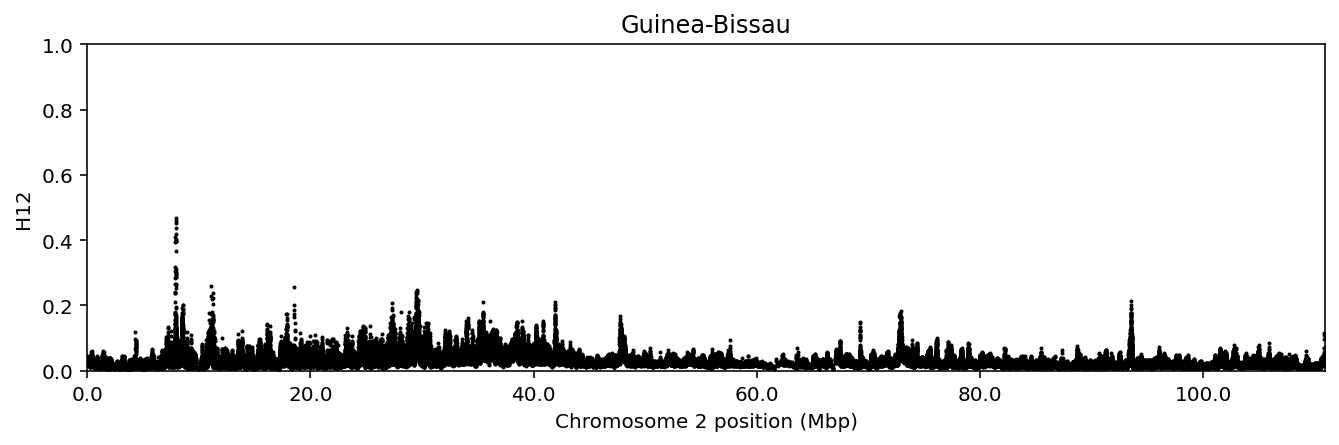

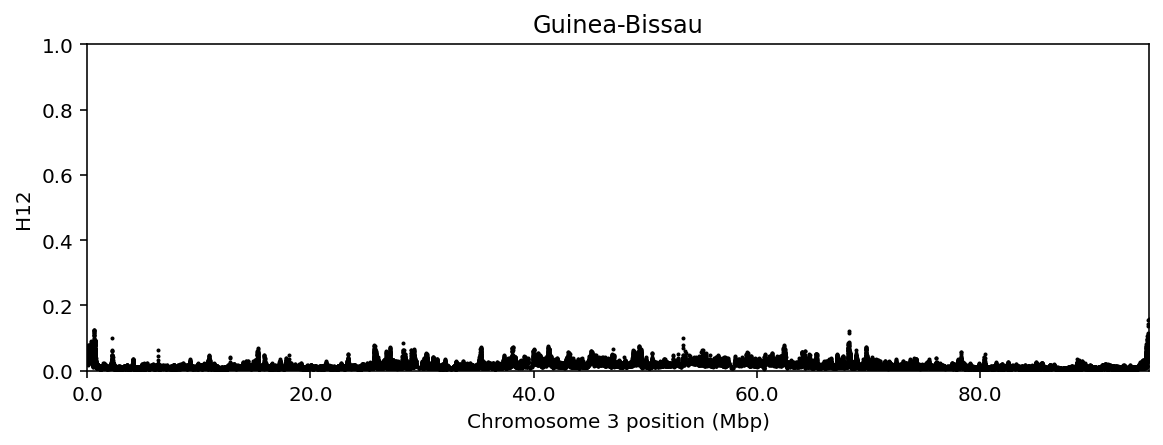

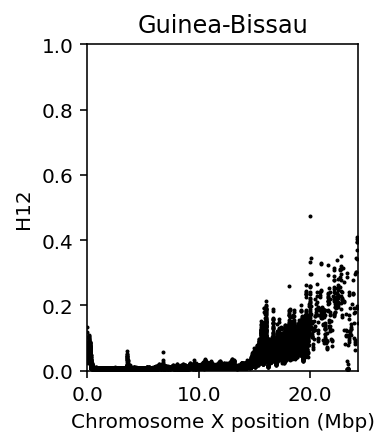

In [24]:
for chromosome in '2', '3', 'X':
    run_h12(pops[12], chromosome)


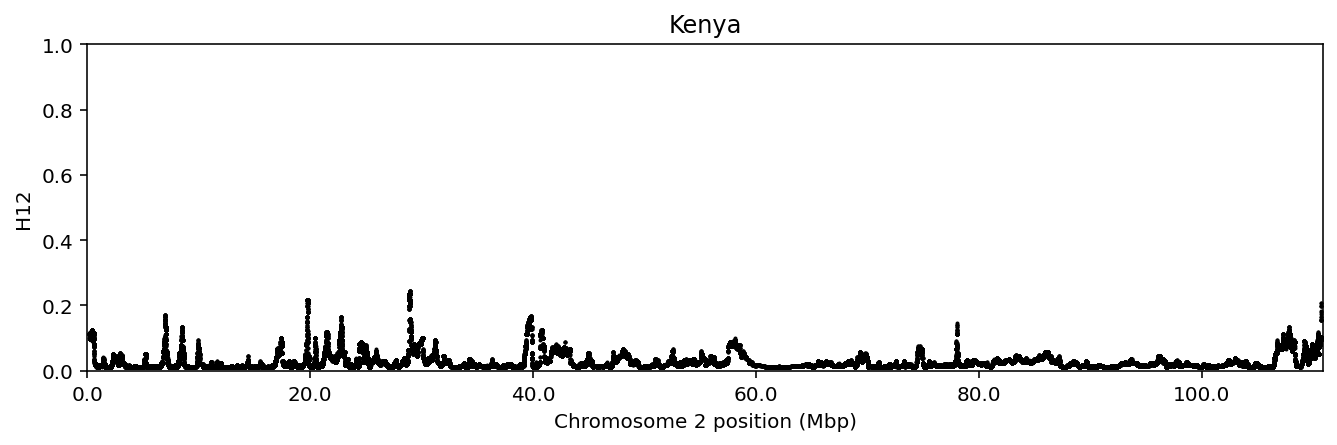

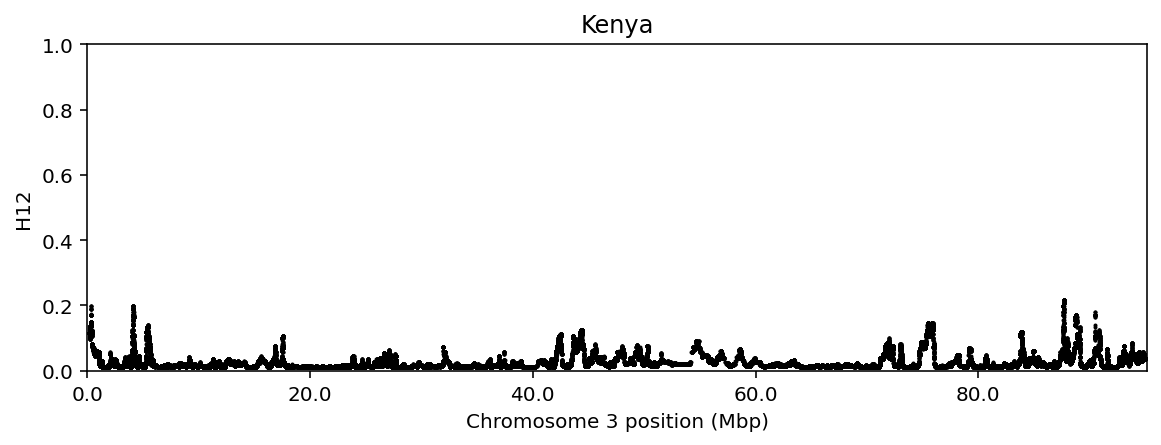

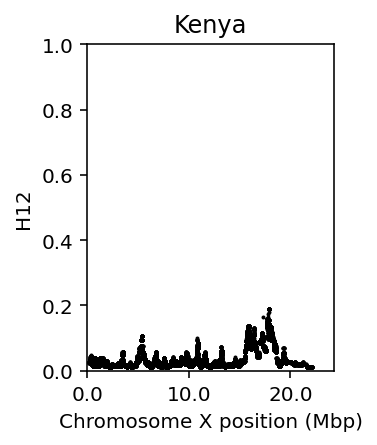

In [25]:
for chromosome in '2', '3', 'X':
    run_h12(pops[13], chromosome)


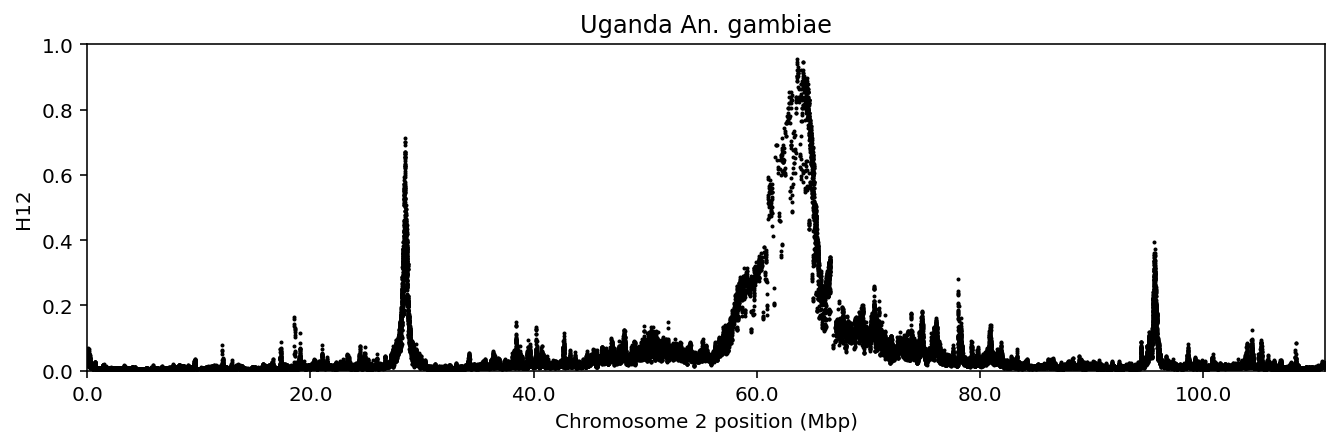

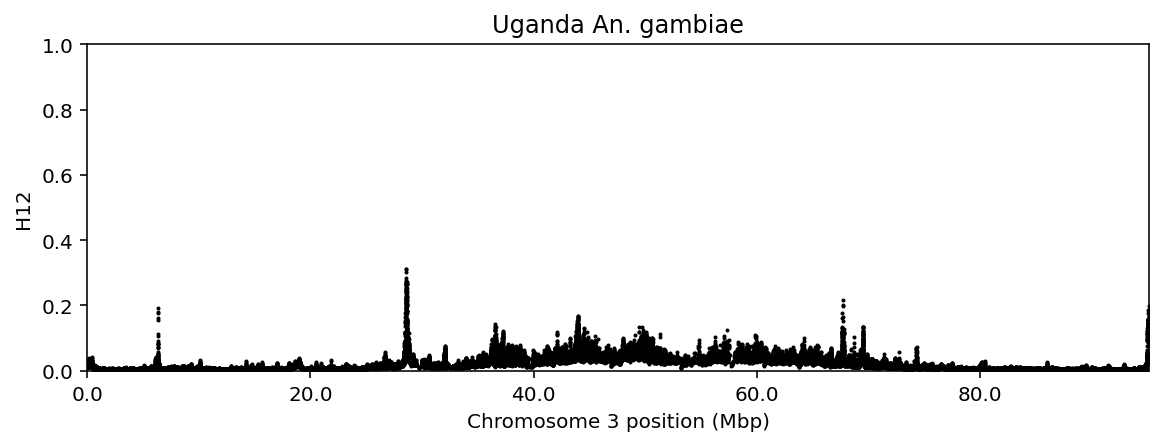

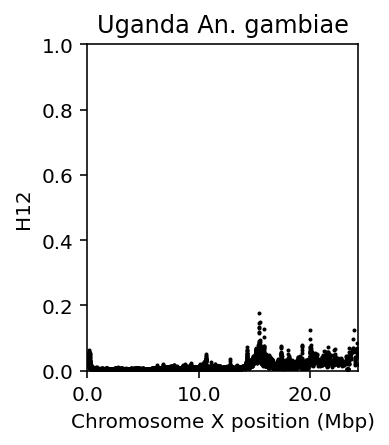

In [26]:
for chromosome in '2', '3', 'X':
    run_h12(pops[14], chromosome)


In [27]:
print(h12_root.tree())

/
 ├── ao_col
 │   └── 6000
 │       └── 200
 │           ├── 2
 │           │   ├── h1 (104742,) float64
 │           │   ├── h12 (104742,) float64
 │           │   ├── h123 (104742,) float64
 │           │   ├── h2_h1 (104742,) float64
 │           │   └── windows (104742, 2) int32
 │           ├── 3
 │           │   ├── h1 (93222,) float64
 │           │   ├── h12 (93222,) float64
 │           │   ├── h123 (93222,) float64
 │           │   ├── h2_h1 (93222,) float64
 │           │   └── windows (93222, 2) int32
 │           └── X
 │               ├── h1 (22332,) float64
 │               ├── h12 (22332,) float64
 │               ├── h123 (22332,) float64
 │               ├── h2_h1 (22332,) float64
 │               └── windows (22332, 2) int32
 ├── bf_col
 │   └── 1000
 │       └── 200
 │           ├── 2
 │           │   ├── h1 (104767,) float64
 │           │   ├── h12 (104767,) float64
 │           │   ├── h123 (104767,) float64
 │           │   ├── h2_h1 (104767,) float64
 │       